# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [20]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

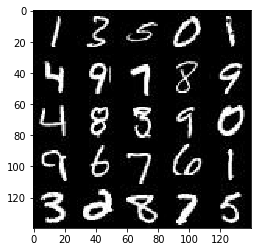

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

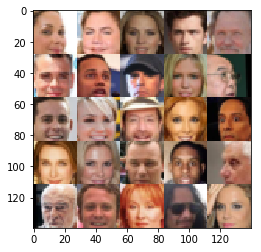

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [24]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32,shape=(None,image_width, image_height, image_channels), name='input_real')
    z_input = tf.placeholder(tf.float32,shape=(None,z_dim),name='input_z')
    lr = tf.placeholder(tf.float32,name='learning_rate')

    return real_input_images, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2

    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x(1 or 3)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
#        print(z.shape)
       # First fully connected layer
        x0 = tf.layers.dense(z, 2*2*1024)
        # Reshape it to start the convolutional stack
        x0 = tf.reshape(x0, (-1, 2,2, 1024))
        # 2x2x1024
        
        x1 = tf.layers.conv2d_transpose(x0, 512, 5, strides=1, padding='valid')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
#        print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
#        print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
#        print(x3.shape)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x 1 or 3 now
        
        out = tf.tanh(logits)
       
#    print(out.shape)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    losses = []
    steps = 0
    n_images=25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1

                batch_images *= 2 # make -0.5 - 0.5 ranget -1.0 - 1.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
#                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})

                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                    
 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8285... Generator Loss: 0.3849


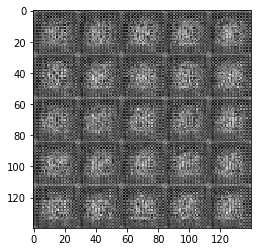

Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.7917


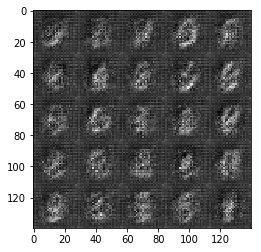

Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 0.6698


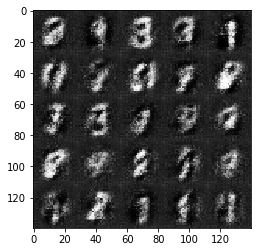

Epoch 1/2... Discriminator Loss: 1.0357... Generator Loss: 1.2956


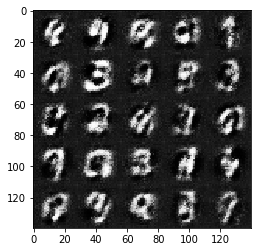

Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 0.6283


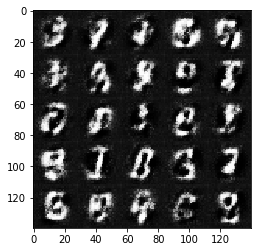

Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.7046


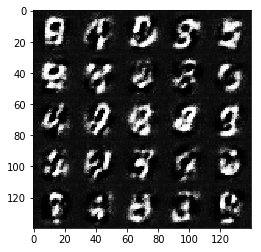

Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 0.9693


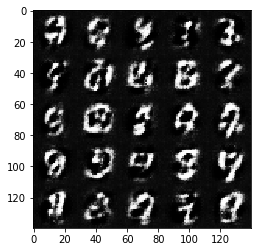

Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 1.2465


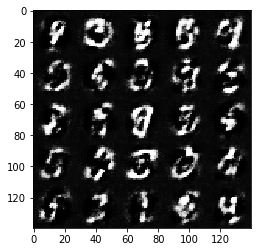

Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 1.0711


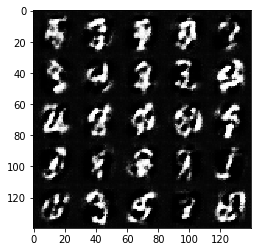

Epoch 1/2... Discriminator Loss: 0.9369... Generator Loss: 0.8458


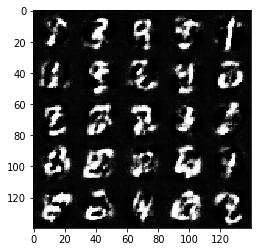

Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 0.5710


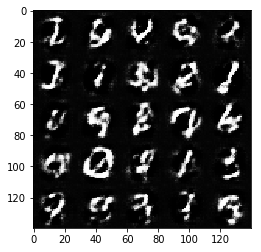

Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.6541


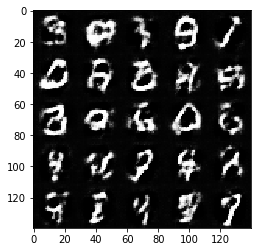

Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 0.7298


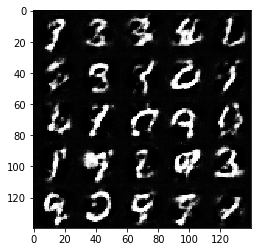

Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.7676


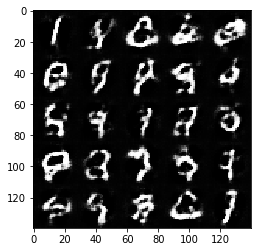

Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.5941


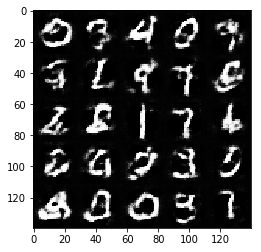

Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 0.6873


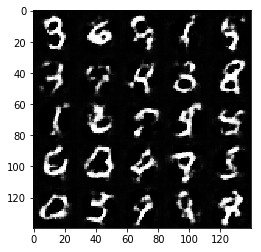

Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 0.9875


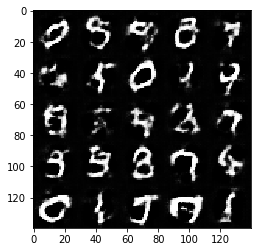

Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.6508


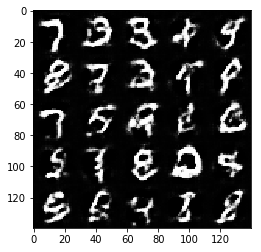

Epoch 2/2... Discriminator Loss: 1.2193... Generator Loss: 0.7006


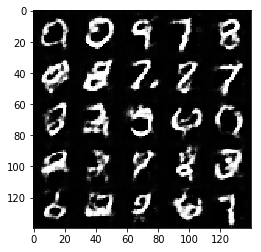

Epoch 2/2... Discriminator Loss: 1.4582... Generator Loss: 0.4488


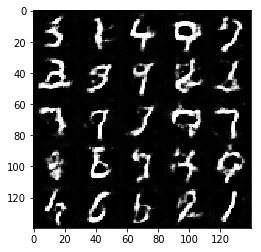

Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 1.0099


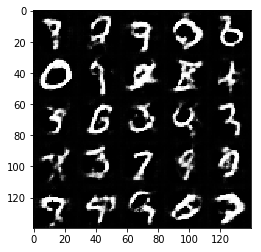

Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 0.6819


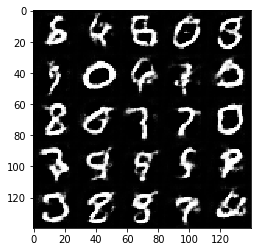

Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 0.9420


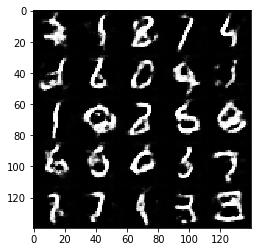

Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 0.5590


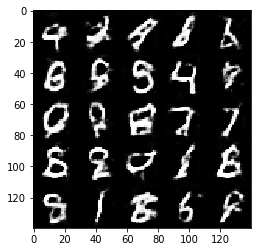

Epoch 2/2... Discriminator Loss: 1.5052... Generator Loss: 0.3721


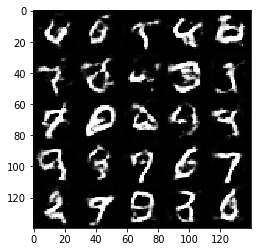

Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.4020


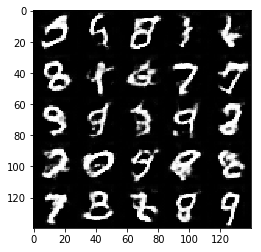

Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 0.6541


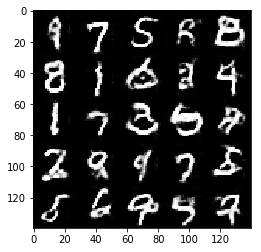

Epoch 2/2... Discriminator Loss: 1.1954... Generator Loss: 0.7329


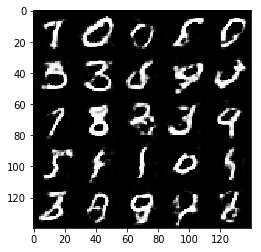

Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.5823


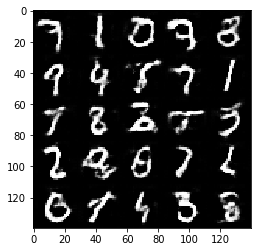

Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 0.8348


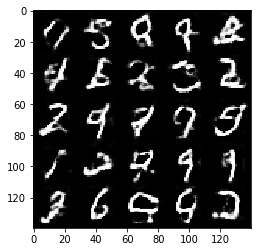

Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.5382


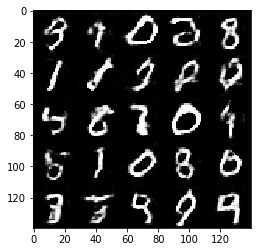

Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 0.5997


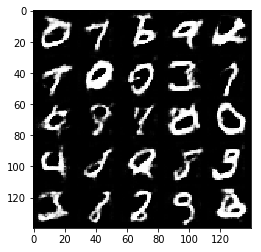

Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 0.9710


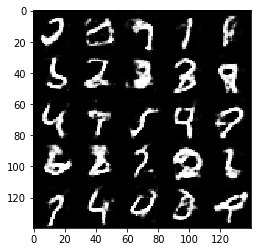

Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 1.1897


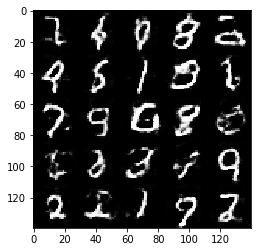

Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 1.0655


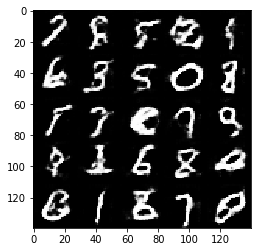

Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 0.8548


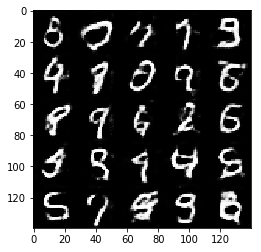

Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 1.2013


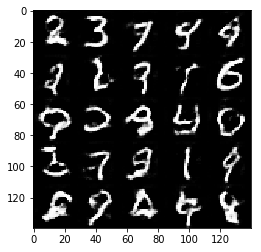

In [31]:
batch_size = 32
z_dim = 100
learning_rate = 0.00002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.5366


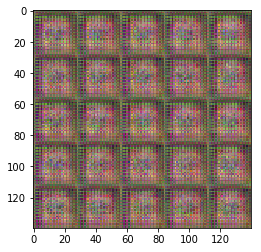

Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 0.8106


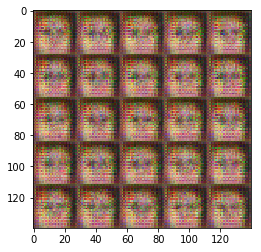

Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 1.3826


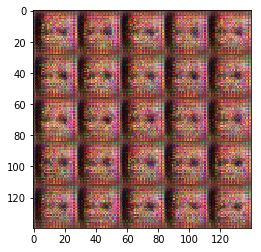

Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 1.5402


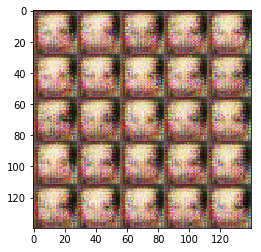

Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.0917


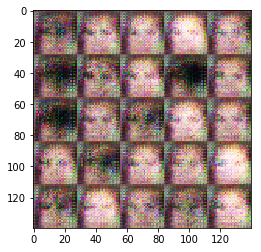

Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 0.9843


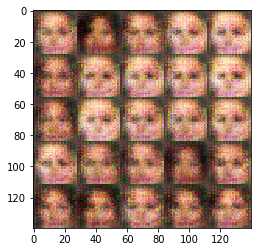

Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 0.9744


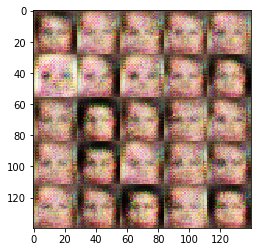

Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.8090


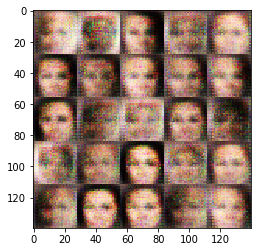

Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.8904


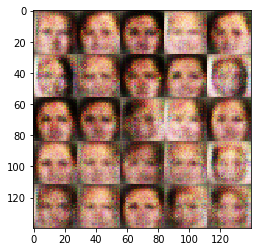

Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.8049


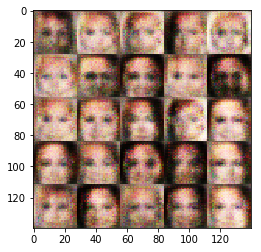

Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.8231


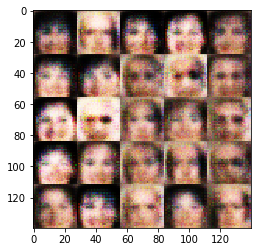

Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6435


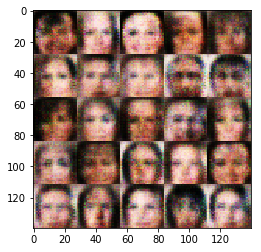

Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8646


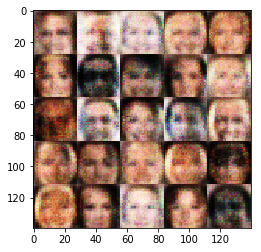

Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7781


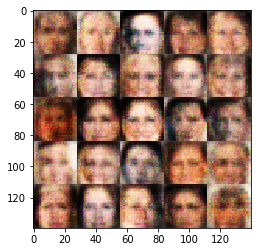

Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6473


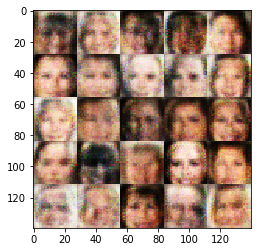

Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8287


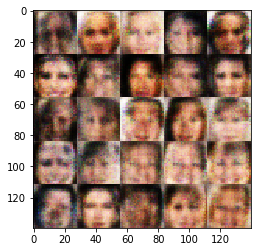

Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.7612


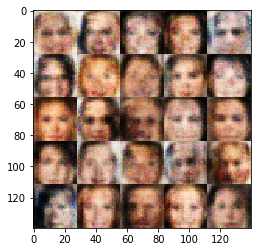

Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8119


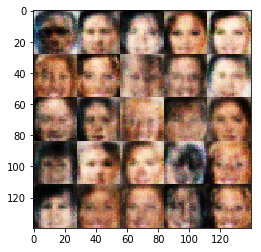

Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8309


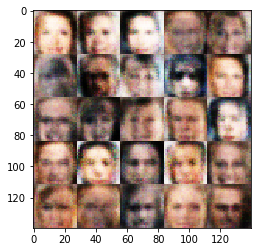

Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7069


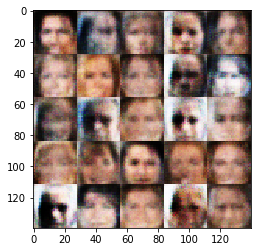

Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.7161


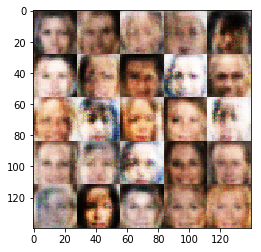

Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6324


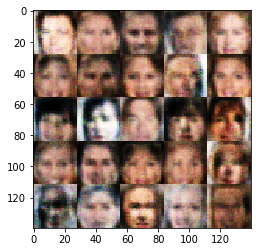

Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.8087


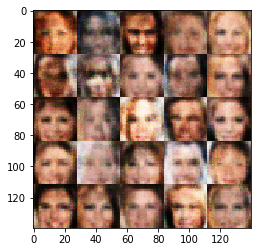

Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8581


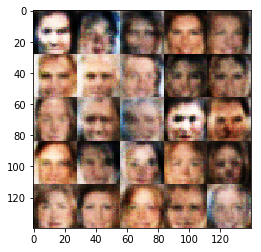

Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6585


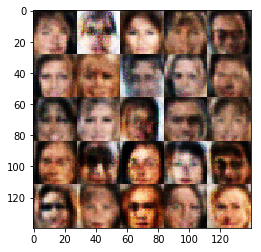

Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.6814


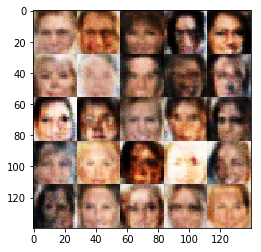

Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7596


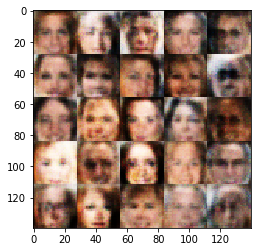

Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7125


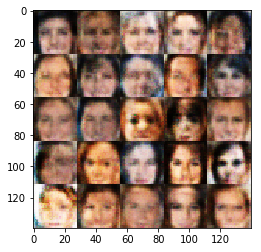

Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6516


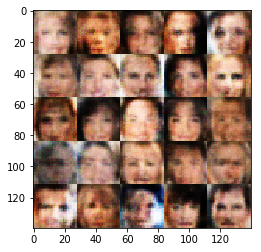

Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6357


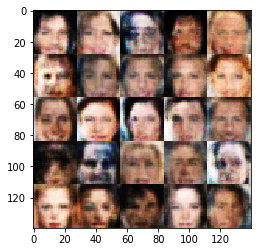

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7288


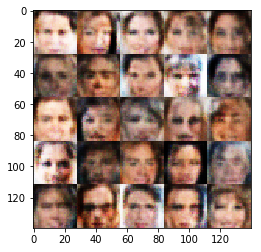

Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.6617


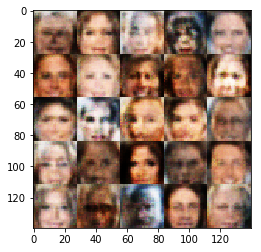

Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6611


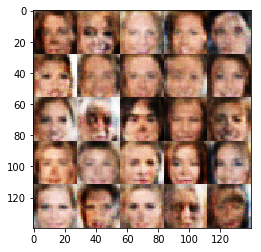

Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6406


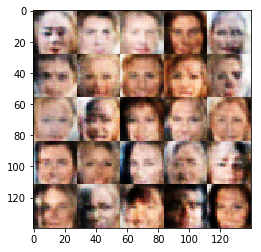

Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.6817


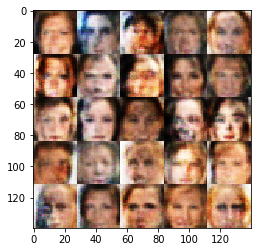

Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6793


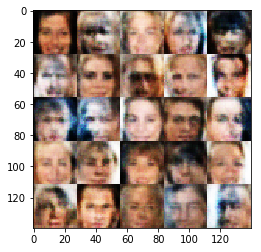

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6665


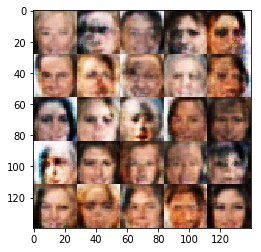

Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.5918


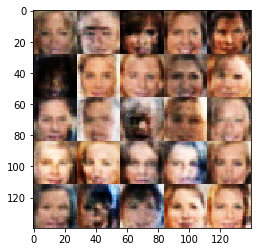

Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6838


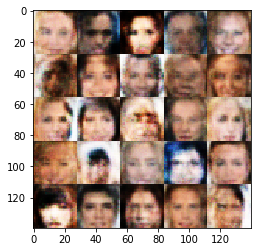

Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6941


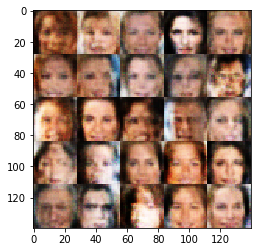

Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.5781


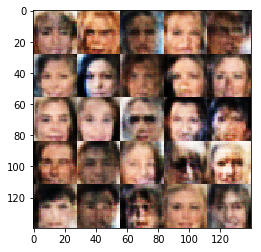

Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6549


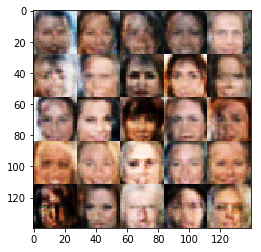

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6766


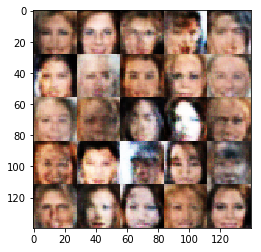

Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.5968


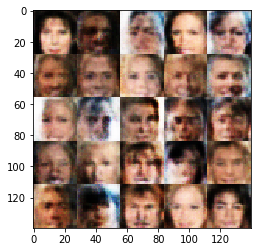

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6823


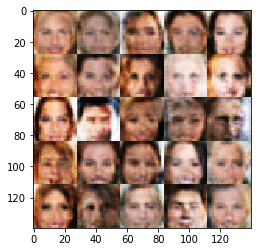

Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6685


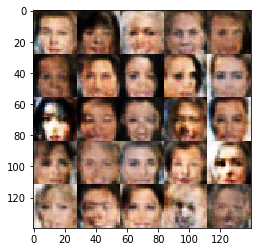

Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6506


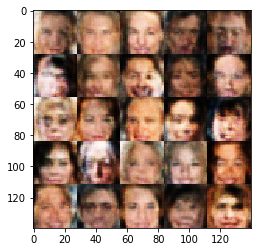

Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6117


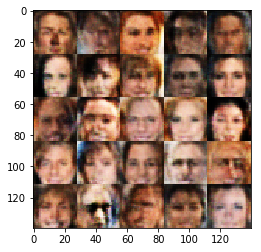

Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6466


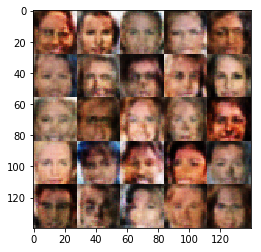

Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6138


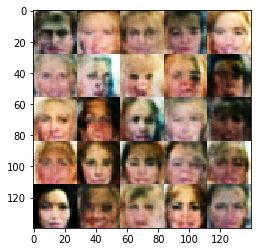

Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.6855


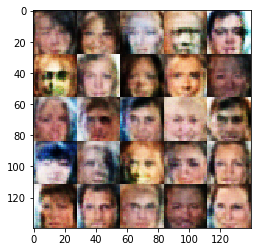

Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6727


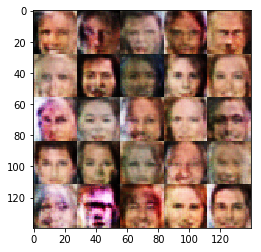

Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6473


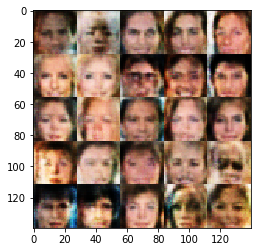

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.6847


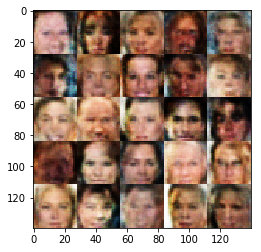

Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6734


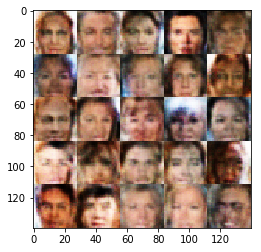

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6212


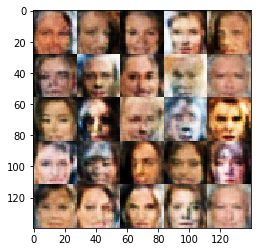

Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6441


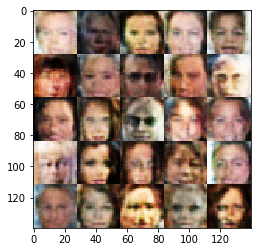

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7036


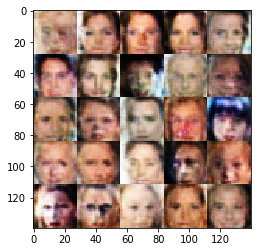

Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6757


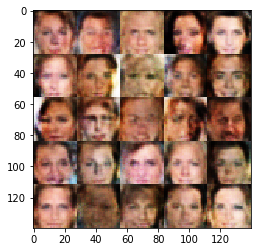

Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6378


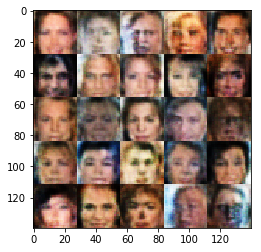

Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6410


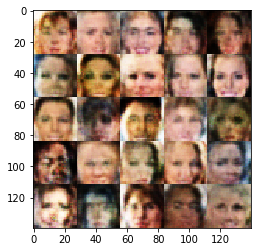

Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7098


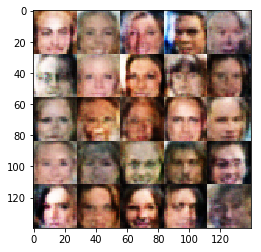

Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6620


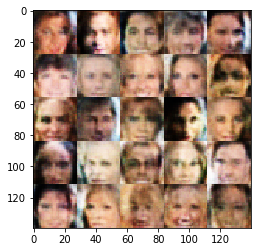

In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.00002
beta1 = 0.1



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.